In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns
import json
import matplotlib.pyplot as plt
from gensim import corpora, models
import pickle
import nltk

In [57]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [58]:
def load_json_to_df(datapass):
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

In [ ]:
business = load_json_to_df("../../../dataset/business.json")

In [ ]:
review = load_json_to_df("../../../dataset/review.json")

In [ ]:
by_city = business.groupby('city').size().reset_index(name='counts')

In [ ]:
by_city.sort_values('counts',ascending=False)

## Overview:
Train the matrix of business subscores by minimizing a loss function for each restaurant, defined by sum((rec - rating)^2), where rec is (rating subscores dot user preference).

We obtain user preference by running an LDA on all the text reviews, that is, we are setting the preference column as a constant in the loss function. 

The weight for each topic is calculated by normalizing the sum of the probabilty that each word of one user's texts occurs in the topics generated by LDA on all reviews.

## Preprocessing:
0. Extract all the restaurant reviews.
1. tokenize
2. stop words
3. stemmize
4. get only nouns and adjs

In [ ]:
is_rest = []
for i in business['categories']:
    
    if 'Restaurants' in i or 'Food' in i:
        is_rest.append(True)
    else:
        is_rest.append(False)
restaurants = business.loc[is_rest]
restaurants.shape

In [13]:
T_restaurant = restaurants.loc[restaurants['city']=='Toronto']

In [14]:
T_restaurant.shape

(8627, 15)

In [15]:
rest_id = T_restaurant['business_id']
rest_review = review.loc[review['business_id'].isin(rest_id)]
rest_review.shape

(312595, 9)

In [16]:
#preprocess
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.corpus import stopwords
en_stop = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

def preprocess(text):
    raw = text.lower()
    tokens = tokenizer.tokenize(raw)
    
    pospeech=[]
    tag = nltk.pos_tag(tokens)
    for j in tag:
        if j[1] == 'NN' or j[1] == 'JJ':
            pospeech.append(j[0])
    # remove stop words from tokens
    stopped_tokens = [i for i in pospeech if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    return stemmed_tokens



In [17]:
NUM_TOPICS = 20
from gensim import corpora, models
'''
def getcorpus(df):
    texts = []
    for i in df['text']:
        texts.append(preprocess(i))
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('../../../dataset/corp.mm', corpus=corpus, id2word=dictionary)
    mm = corpora.MmCorpus('../../../dataset/corp.mm')
    return mm, dictionary

def getlda(dictionary):
    mm = corpora.MmCorpus('../../../dataset/corp.mm')
    # generate LDA model
    ldamodel = models.ldamulticore.LdaMulticore(mm, num_topics=NUM_TOPICS, id2word = dictionary, workers=15, passes=1, eval_every=None)
    return ldamodel
'''
def getcorpuse(df):
    texts = []
    for i in df['text']:
        texts.append(preprocess(i))
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus, dictionary
def getlda(corpus, dictionary):
    
    ldamodel = models.ldamulticore.LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word = dictionary, workers=3, passes=1, eval_every=None)
    return ldamodel


## Calculate preference maxtrix
Add up the probabity that each word in the corpus in each topic, then add up for each topic and normalize.

In [18]:
def getprefer(userid, ldamodel, df):
    user_reviews = df.loc[df['user_id'] == userid]
    l = np.zeros(NUM_TOPICS)
    texts = []
    for t in user_reviews['text']:
        texts.append(preprocess(t))
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    for i in ldamodel.get_document_topics(corpus):
        for topic in i:
            l[topic[0]] += topic[1]
    topic_likelihood = []
    sum_l = sum(l)
    if sum_l > 0:
        for i in l:
            topic_likelihood.append(i/sum(l))
    else:
        topic_likelihood = np.full(NUM_TOPICS, 1/NUM_TOPICS)
    return topic_likelihood

## Minimize loss function

Since we setting the topics for each user as constant, the corpus likelihood here is a constant so we only need to deal with rating error.

We used Sequential Least SQuares Programming (SLSQP) to minize the function.

Intial guess was randomized between 1.0 and 5.0

Might need to explore bias and hyperparameters in the future.

In [19]:
from scipy.optimize import minimize
def min_loss(raw_prefer, actual_rating):
    dim = NUM_TOPICS
    prefer = []
    for i in raw_prefer:
        prefer.append(np.asarray(i, dtype=np.float32))
    prefer = np.asarray(prefer)
    bound = []
    for i in range(0,dim):
        bound.append((1.0,5.0))
    bnds = tuple(bound)


    def f(x,prefer,actual_rating):

        return sum(abs(np.dot(x,np.transpose(prefer)) - actual_rating))
    initial_guess = [np.random.uniform(1.0,5.0,dim)]
    #initial_guess = np.full(5,2.5)
    try:
        result = minimize(f, initial_guess, args=(prefer,actual_rating), method='SLSQP', bounds=bnds, options={'disp': False, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 1000, 'ftol': 1e-06})
    except:
        return -1
    if result.success:
        fitted_params = result.x
        '''
        print ("param")
        print(fitted_params)
        print ("fun")
        print(result.fun)
        print(result.nit)
        '''
        return result
    else:
        return -1

## Combine everything
For each restaurant, run the algorithm to get the subscores, which will take a couple days on MacBook ~~Pro~~.

In [20]:
def add_prefer_to_df(df, lda, groupbyusers):
    d = {}
    new_df = df
    for u in groupbyusers['user_id']:
        d[u] = getprefer(u,lda,new_df)
    df['preference'] = df.apply(lambda x: d[x['user_id']],axis=1)
    return new_df

In [21]:
def train_rest_subscore(bizid, df):
    biz = df.loc[df['business_id'] == bizid]
    rating = biz['stars']
    preference = biz['preference']
    result = min_loss(preference.values, rating.values)
    return result.x

In [22]:
def getsubscore(df, groupbybiz):
    d = {}
    counter = 0
    for u in groupbybiz['business_id']:
        counter +=1
        if (counter %1000 ==0):
            print (counter)
        d[u] = train_rest_subscore(u, df)
    #df['subscore'] = df.apply(lambda x: d[x['business_id']],axis=1)
    return d

In [23]:
from sklearn.model_selection import train_test_split
def split(groupbybiz, df):
    trains = []
    tests = []
    for i in groupbybiz['business_id']:
        biz = df.loc[df['business_id'] == i]
        train, test = train_test_split(biz, test_size=0.30, random_state=42)
        trains.append(train)
        tests.append(test)
    train_df = pd.concat(trains)
    test_df = pd.concat(tests)
    return train_df, test_df

In [24]:
groupby_rest = rest_review.groupby('business_id').size().reset_index(name='counts')

In [25]:
#train_df, test_df = split(groupby_rest, rest_review)

In [26]:
groupby_user = rest_review.groupby('user_id').size().reset_index(name='counts')

In [ ]:
corp, diction = getcorpuse(rest_review)

In [ ]:
lda = getlda(corp, diction)

In [ ]:
lda.save("../../../dataset/lda")

In [ ]:
#mm, diction = getcorpus(rest_review)

In [33]:
#lda = getlda(diction)

In [ ]:
prefer_added = add_prefer_to_df(rest_review, lda, groupby_user)

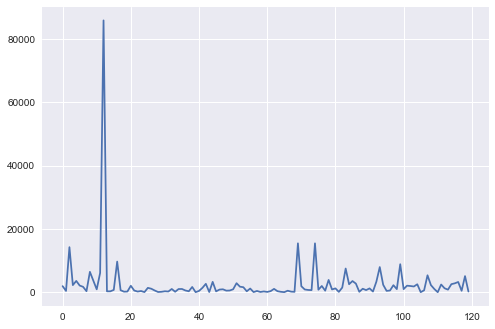

In [36]:
l = list(np.empty(NUM_TOPICS))
for i in prefer_added['preference']:
    for p in range(len(i)):
        l[p] += i[p]
plt.plot(l)

In [43]:
l[12]

85749.090054671629

In [44]:
lda.print_topic(12,30)

'0.106*"steak" + 0.043*"seafood" + 0.040*"medium" + 0.037*"good" + 0.028*"rare" + 0.028*"fix" + 0.020*"creme" + 0.018*"shrimp" + 0.018*"sauc" + 0.013*"prix" + 0.013*"menu" + 0.012*"pepper" + 0.012*"brule" + 0.008*"salt" + 0.008*"dish" + 0.008*"salad" + 0.007*"dinner" + 0.007*"meal" + 0.007*"filet" + 0.007*"top" + 0.007*"dessert" + 0.007*"flavour" + 0.006*"restaur" + 0.006*"food" + 0.006*"servic" + 0.006*"time" + 0.006*"sirloin" + 0.006*"side" + 0.006*"boil" + 0.005*"bit"'

In [45]:
subscores = getsubscore(prefer_added, groupby_rest)

1000
2000
3000
4000
5000
6000
7000
8000


In [49]:
prediction = []
for i in range(len(prefer_added)):
    prediction.append(np.dot(prefer_added.iloc[i]['preference'], subscores[prefer_added.iloc[i]['business_id']]))

In [50]:
expected = prefer_added['stars']

In [51]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected.values, prediction)
print('MSE: %f' % mse)

MSE: 1.078841


In [52]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected.values, prediction)
print('MAE: %f' % mae)

MAE: 0.712545


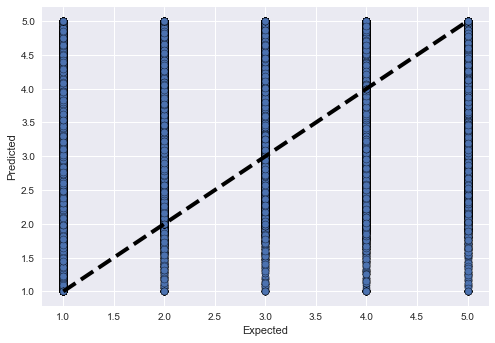

In [53]:
fig, ax = plt.subplots()
y = expected.values
ax.scatter(y, prediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Expected')
ax.set_ylabel('Predicted')
plt.show()

In [109]:
sample = rest_review.sample(50000)

In [110]:
sample_lda = getlda(sample)

In [111]:
groupby_user_sample = sample.groupby('user_id').size().reset_index(name='counts')

In [112]:
perfer_added_to_sample = add_prefer_to_df(sample, sample_lda, groupby_user_sample)

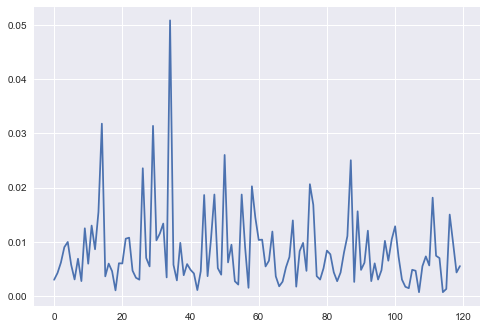

In [113]:
prefer_added_to_sample = perfer_added_to_sample
plt.plot(prefer_added_to_sample['preference'].iloc[1])

In [ ]:
l = list(np.empty(NUM_TOPICS))
for i in prefer_added_to_sample['preference']:
    for p in range(len(i)):
        l[p] += i[p]
print (l)

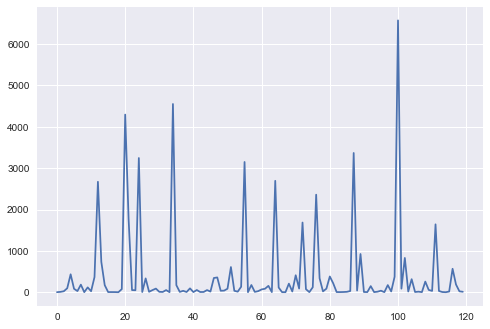

In [115]:
plt.plot(l)

## Future
Evaluating the performance.

Come up with a method that does not set the topics as a whole but one for each user. However, we are struggling to see how to match topics between user and restaurant without manual labelling.